# EM Algorithm and Gibbs Sampler: Applications to a Hierarchical Latent Variable Model

### ***Maria Salunina, Yabra Muvdi, Vivek Kai-wen, Keyvan Amini***


Latent variable models are a powerful tool in statistics to deal with situations in which a variable cannot be observed but, presumably, has an important effect on a quantity of interest. Latent variables can be applied to hierarchical regression models where the goal is to capture the random effect of these unobserved factors. By splitting the regression problem into multiple levels, we can drastically reduce the complexity of our models and prevent overfitting. For illustration purposes, we will reference the radon contamination study by [Gelman & Hill (2007)](https://www.cambridge.org/core/books/data-analysis-using-regression-and-multilevelhierarchical-models/32A29531C7FD730C3A68951A17C9D983). However, the statistical model and tools we develop here can be used for a broad range of situations. The main aim of this notebook will be to develop a clear understanding of the hierarchical latent variable model through the implementation of two main methods to estimate this model: the EM Algorithm and the Gibbs Sampler. 

One might wonder why we do not simply add dummy variables for each county. This approach of having separate features for all categorical variables will lead to thousands of features for each county, whereas the multilevel approach reduces the complexity to only five parameters. This will allow us to make inferences about the effects of the latent variables across different counties.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import random
import scipy

from pymc3 import Model, sample, Normal, Uniform, model_to_graphviz, Deterministic, summary
from scipy.stats import invgamma
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# Content
1. [Data Generating Process](#first)
2. [EM-Algorithm](#second)
3. [Gibbs Sampling](#third)
    1. [External Implementation _pymc3_](#third-first)
    2. [Analytical Implemetation](#third-second)
4. [Radon Data](#fourth)
    1. [EM-Algorithm](#fourth-first)
    2. [Gibbs Sampling](#fourth-second)
        1. [External Implementation _pymc3_](#fourth-second-first)
        2. [Analytical Implemetation](#fourth-second-second)
5. [Robustness Checks and Experimentation](#fifth)
    1. [Different Distributions for $x$ ($y$-covariate)](#fifth-first)
        1. [Normal Distribution](#fifth-first-first)
        2. [Poisson Distribution](#fifth-first-second)
    2. [Different Distributions for $u$ ($z$-covariate)](#fifth-second)
        1. [Exponential Distribution](#fifth-second-first)
        2. [Normal Distribution](#fifth-second-second)
    3. [Correlation Level between $z$ and $x$](#fifth-third)
    4. [Number of Households per County](#fifth-fourth)
    5. [Number of Counties](#fifth-fifth)

# Data Generating Process
<a class="anchor" id="first"></a>

In [3]:
def generate_u_z(M, a, b, psi, u_distr='uniform', **kwargs):
    '''Returns simulated latent variable (z) together with corresponding covariates (u)'''
    np.random.seed(4242)
    df = pd.DataFrame(columns=['u', 'z']) 
    for i in range(M):
        
        # u_j simulation
        if u_distr == 'uniform':
            u_j = np.random.uniform(low=kwargs['low'], high=kwargs['high'])
        elif u_distr == 'exponential':
            u_j = np.random.exponential(scale=kwargs['scale'])
        elif u_distr == 'normal':
            u_j = np.random.normal(loc=kwargs['loc'], scale=kwargs['scale'])
        
        # z_j simulation
        z_j = np.random.normal(loc=(a + b*u_j), scale=psi**(1/2))
        df = df.append({'u':u_j, 'z':z_j}, ignore_index=True)
    return df

def generate_households_distribution(N, M, distr='normal', **kwargs):
    ''' Return number of households splitted between counties with a given distribution '''
    np.random.seed(4242)
    if distr == 'normal':
        probabilities = np.random.normal(loc=kwargs['loc'], scale=kwargs['scale'], size=M)
    elif distr == 'gamma':
        probabilities = np.random.gamma(shape=kwargs['shape'], scale=kwargs['scale'], size=M)
        
    # normalize probabilities to sum up to 1    
    probabilities /= np.sum(probabilities)
    
    # generate number of households per county
    num_households = np.random.multinomial(N, probabilities, 1)[0]
    return sorted(num_households, reverse=True)

def generate_x_y(df_uz, num_households, counties_params, beta, phi, x_distr='binomial'):
    '''Returns simulated target variable (y) together with its input features (x)'''
    df = pd.DataFrame(columns=['u', 'z', 'x', 'y'])
    np.random.seed(4242)
    for j, num in enumerate(num_households):
        u_j, z_j = df_uz['u'][j], df_uz['z'][j]
        corr_param = counties_params[j]
        for i in range(num):
            
            if x_distr == 'binomial':
                x_i = np.random.binomial(n=1, p=corr_param)
            elif x_distr == 'normal':
                x_i = np.random.normal(loc=corr_param[0], scale=corr_param[1])
            elif x_distr == 'poisson':
                x_i = np.random.poisson(lam=corr_param)
            
            y_i = np.random.normal(loc=(z_j + beta*x_i), scale=phi**(1/2))
            df = df.append({'u':u_j, 'z':z_j, 'x':x_i, 'y':y_i, 'county': j}, ignore_index=True)
    df.county = df.county.astype(int)
    return df 

,u,z,x,y,county
0,3.249495,6.188042,1.0,8.126589,0
1,3.249495,6.188042,1.0,6.477009,0
2,3.249495,6.188042,1.0,8.422881,0


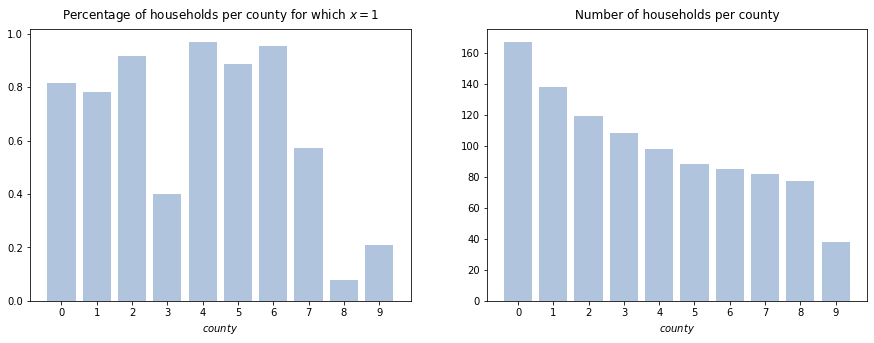

In [3]:
N = 1000
M = 10
theta = {'a':2, 'b':1, 'beta':1, 'psi':1, 'phi':1}

num_households = generate_households_distribution(N, M, distr='gamma', shape=9, scale=1)
counties_params = np.random.uniform(0, 1, M)

df_uz = generate_u_z(M, theta['a'], theta['b'], theta['psi'], u_distr='uniform', low=0, high=10)
df = generate_x_y(df_uz, num_households, counties_params, theta['beta'], theta['phi'], x_distr='binomial')
display(df.head(3))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
ax[0].bar(range(M), df.groupby('county').sum().x / df.groupby('county').count().x, color='lightsteelblue')
ax[0].set_title('Percentage of households per county for which $x=1$', pad=10)
ax[0].set_xticks(range(M))
ax[0].set_xlabel('$county$')
ax[1].bar(x=range(M), height=num_households, color='lightsteelblue')
ax[1].set_title('Number of households per county', pad=10)
ax[1].set_xticks(range(M))
ax[1].set_xlabel('$county$');

# EM-Algorithm
<a class="anchor" id="second"></a>

In [4]:
class EMAlgorithm():
    def __init__(self, df):
        self.df = df
        self.y = df['y'].values
        self.x = df['x'].values
        self.m = len(df['u'].unique())
        self.theta = None
        self.likelihood = []
        self.thetas_convergence = []
        
    def get_county_data(self):
        self.mean_y_j = self.df.groupby('u').mean()['y'].values
        self.mean_x_j = self.df.groupby('u').mean()['x'].values
        self.n_j = self.df.groupby('u').count()['y'].values
        self.u_j = self.df.groupby('u').count()['y'].index.values
        
    def get_j_county_vectors(self, i, u):
        x_j = self.df['x'][self.df['u'] == u].values.reshape((-1, 1))
        y_j = self.df['y'][self.df['u'] == u].values.reshape((-1, 1))
        z_j = (self.z_j[i] * np.ones(self.n_j[i])).reshape((-1, 1))
        return x_j, y_j, z_j
        
    def get_loglikelihood(self):
        term1_1 = (1/2)*math.log(2*math.pi*self.theta['phi'])*np.sum(self.n_j)
        term1_2 = (((self.y**2 + (self.theta['beta']**2)*(self.x**2) - 2*self.theta['beta']*self.x*self.y \
                     + 2*(self.theta['beta']*self.x - self.y)*self.z_i + self.z2_i)) \
                   /(2*self.theta['phi'])).sum()
        term2 = []
        for j, u in enumerate(self.u_j):
            term2_1 = (1/2)*math.log(2*math.pi*self.theta['psi'])
            term2_2 = ((self.theta['a']**2 + (self.theta['b']**2)*(u**2) \
                        + 2*self.theta['a']*self.theta['b']*u  \
                        - 2*(self.theta['a'] + self.theta['b']*u)*self.z_j[j] \
                        + self.z2_j[j])/(2*self.theta['psi']))
            
            term2.append(term2_1 + term2_2)
        
        term2 = np.sum(term2)
        l = -term1_1 - term1_2 - term2
        return l
    
    def get_z_i_vector(self):
        df_uz = pd.DataFrame({'u': self.u_j, 'z_exp': self.z_j,'z2_exp': self.z2_j})
        self.df = self.df.merge(df_uz, how='left', on='u')
        self.z_i = self.df['z_exp'].values
        self.z2_i = self.df['z2_exp'].values
        del self.df['z_exp']
        del self.df['z2_exp']
            
    def update_expected_z(self):
        hshld_level = (self.n_j/self.theta['phi'])/(self.n_j/self.theta['phi'] + 1/self.theta['psi']) * \
                            (self.mean_y_j - self.theta['beta']*self.mean_x_j)
        county_level = (1/self.theta['psi'])/(self.n_j/self.theta['phi'] + 1/self.theta['psi']) * \
                            (self.theta['a'] + self.theta['b']*self.u_j)
        
        self.z_j = hshld_level + county_level
        self.z2_j = (self.z_j)**2 + 1/((self.n_j/self.theta['phi']) + (1/self.theta['psi']))
        self.get_z_i_vector()
     
    def initialize_parameters(self):
        self.theta = {}
        self.theta['a'] = random.uniform(-10, 10)
        self.theta['b'] = random.uniform(-10, 10)
        self.theta['beta'] = random.uniform(-10, 10)
        self.theta['phi'] = random.uniform(0, 10)
        self.theta['psi'] = random.uniform(0, 10)
        self.thetas_convergence.append(self.theta)
    
    def update_parameters(self):
        # a
        num = (self.z_j - self.u_j * (self.z_j * self.u_j).sum() / (self.u_j**2).sum()).sum()
        denom = self.m - (self.u_j * (self.u_j).sum() / (self.u_j**2).sum()).sum()
        a = num / denom
        
        # b
        b = (self.z_j * self.u_j - a * self.u_j).sum() / (self.u_j**2).sum()
        
        # beta
        beta = ((self.y - self.z_i) * self.x).sum() / (self.x**2).sum()
        
        # Phi updated 
        phi = ((self.y**2 + (beta**2)*(self.x**2) - 2*beta*self.x*self.y \
                + 2*(beta*self.x - self.y)*self.z_i + self.z2_i).sum()) * (1/np.sum(self.n_j))
        
        # Psi updated
        psi = (1/self.m) * ((a**2 + (b**2)*(self.u_j**2) + 2*a*b*self.u_j - \
                             (2*a + 2*b*self.u_j)*self.z_j + self.z2_j)).sum()
        
        # Update parameters
        self.theta = {'a':a, 'b':b, 'beta':beta, 'phi':phi, 'psi':psi}
        self.thetas_convergence.append(self.theta)

    def fit(self):
        self.get_county_data()
        self.initialize_parameters()
        self.update_expected_z()
        self.likelihood.append(self.get_loglikelihood())
    
        diff_likelihood = np.inf
        while abs(diff_likelihood) > 0.001:
            self.update_expected_z()
            self.update_parameters()
            self.likelihood.append(self.get_loglikelihood())
            diff_likelihood = self.likelihood[-1] - self.likelihood[-2]

In [10]:
class Validation():
    def __init__(self, df, true_theta=None, rounds=10, print_rounds=False):
        self.df = df
        self.true_theta = true_theta
        self.rounds = rounds
        self.likelihoods = []
        self.thetas = []
        self.z_i = []
        self.print_rounds = print_rounds
        self.estimates = {}
    
    def mean_squared_error(self, z_true, z_predicted):
        return ((z_true - z_predicted)**2).sum() / z_true.shape[0]
    
    def run_em_validation(self):
        for i in range(1, self.rounds+1):
            start = datetime.now()
            ema = EMAlgorithm(self.df)
            ema.fit()
            end = datetime.now()
            if self.print_rounds:
                print(f'Elapsed time (round {i}): {end - start}')
                mse = self.mean_squared_error(self.df.z, ema.z_i)
                print(f'Loglikelihood = {ema.likelihood[-1]}')
                print(f'MSE(z, z_hat) = {mse} \n')
            self.likelihoods.append(ema.likelihood)
            self.thetas.append(ema.thetas_convergence)
        self.params = list(self.thetas[0][0].keys())
        
        for k, key in enumerate(self.params):
            avg_optimal_key = []
            for round_i in self.thetas:
                avg_optimal_key.append(round_i[-1][key])
            self.estimates[key] = np.mean(avg_optimal_key)
    
    def plot_likelihood(self, scale):
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(15,5)
        fig.suptitle('Loglikelihood', fontsize=20, va='center')

        ax[0].set_title("Loglikelihood convergence", fontsize=14, pad=10)
        for i, j in enumerate(self.likelihoods):
            ax[0].plot([i/len(j) for i in range(len(j))], j)

        ax[1].set_title("Loglikelihood convergence (scaled)", fontsize=14, pad=10)
        ax[1].set_ylim(scale[0], scale[1])
        for i, j in enumerate(self.likelihoods):
            ax[1].plot([i/len(j) for i in range(len(j))], j)
    
    def plot_theta(self):
        fig, ax = plt.subplots(3, 2)
        fig.set_size_inches(15, 15)

        axes_ij = [(0,0), (0,1), (1,0), (1,1), (2,0)]
        for k, key in enumerate(self.params):
            key_convergence = []
            avg_optimal_key = []
            for round_i in self.thetas:
                key_convergence.append([j[key] for j in round_i])
                avg_optimal_key.append(round_i[-1][key])
            avg_optimal_key = np.mean(avg_optimal_key)

            ax_i, ax_j = axes_ij[k][0], axes_ij[k][1]
            for i, j in enumerate(key_convergence):
                ax[ax_i][ax_j].plot([i/len(j) for i in range(len(j))], j)
            if self.true_theta is not None:    
                ax[ax_i][ax_j].hlines(self.true_theta[key], xmin=0, xmax=1, linestyles='dashed')
            title = f"${key}$ converges to: {round(avg_optimal_key, 1)}"
            ax[ax_i][ax_j].set_title(title, fontsize=14)
            
        fig.get_axes()[0].annotate('Parameters', (0.5, 0.94), 
                                   xycoords='figure fraction', ha='center', fontsize=20)
        fig.subplots_adjust(hspace=0.3)
        fig.delaxes(ax[2,1]);

In [11]:
def run_ema(df, scale=(-3500, 0)):
    em_test = Validation(df)
    em_test.run_em_validation()
    return em_test.estimates

In [7]:
em_test = Validation(df, true_theta=theta)
em_test.run_em_validation()

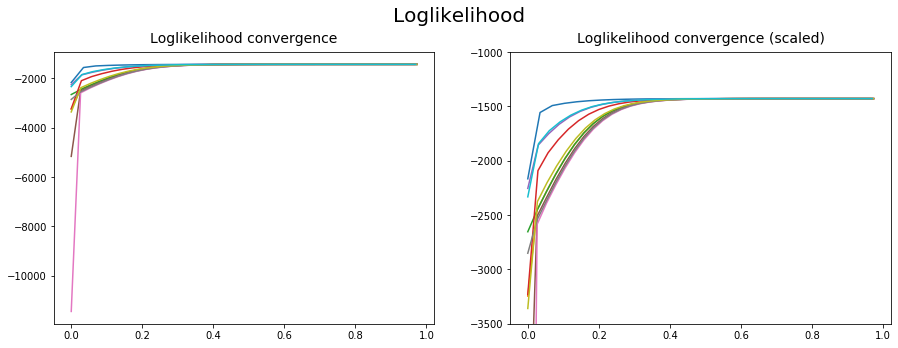

In [8]:
em_test.plot_likelihood(scale=(-3500, -1000))

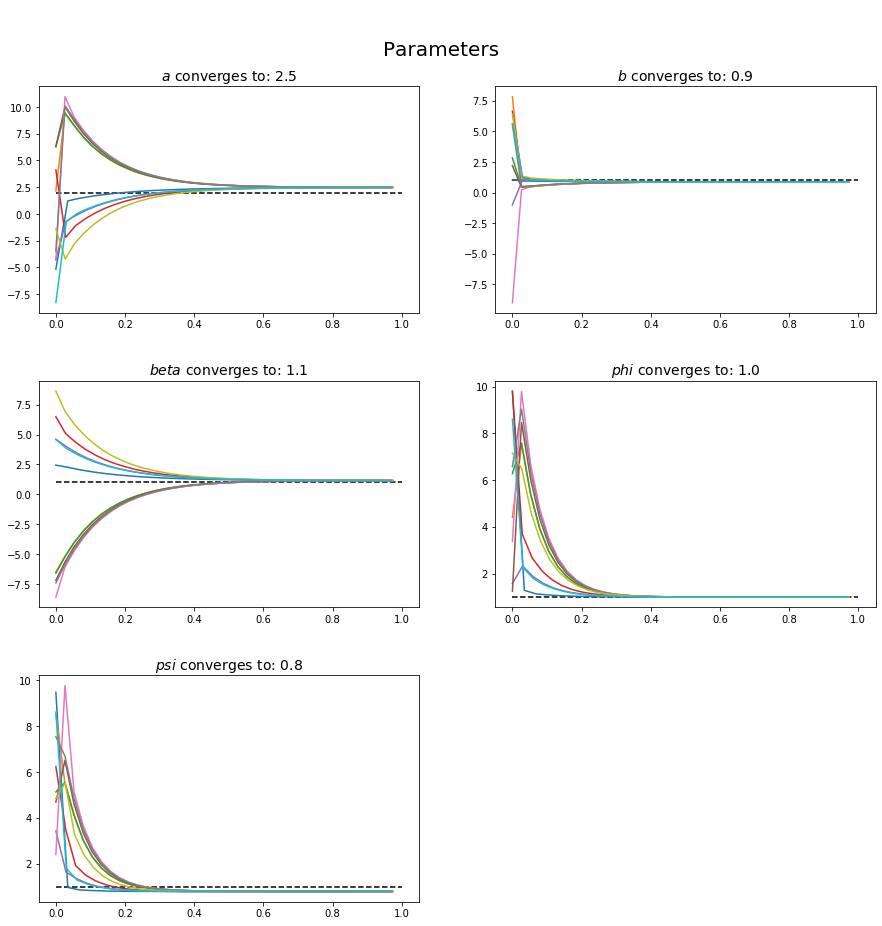

In [9]:
em_test.plot_theta()

# Gibbs Sampling
<a class="anchor" id="third"></a>
## External Implementation *pymc3* 
<a class="anchor" id="third-first"></a>

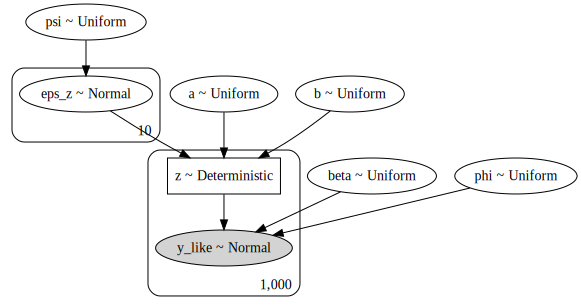

In [10]:
with Model() as hierarchical_intercept:

    psi = Uniform('psi', lower=0, upper=10)
    a = Uniform('a', lower=-10, upper=10)
    b = Uniform('b', lower=-10, upper=10)
    
    mu_z = a + b * df['u']
    eps_z = Normal('eps_z', mu=0, sigma=psi, shape=len(df.county.unique()))
    z = Deterministic('z', mu_z + eps_z[df['county']])

    beta = Uniform('beta', lower=-10, upper=10)
    phi = Uniform('phi', lower=0, upper=10)
    
    y_hat = z + beta * df['x']
    y_like = Normal('y_like', mu=y_hat, sigma=phi, observed=df['y'])

model_to_graphviz(hierarchical_intercept)

In [11]:
with hierarchical_intercept:
    hierarchical_intercept_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, beta, eps_z, b, a, psi]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [01:24<00:00, 26.30draws/s] 
The acceptance probability does not match the target. It is 0.9128914466392053, but should be close to 0.8. Try to increase the number of tuning steps.


In [12]:
summary(hierarchical_intercept_trace, var_names=['a', 'b', 'psi', 'beta', 'phi'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,2.499,0.950,0.754,4.362,0.028,0.020,1124.0,1124.0,1150.0,1245.0,1.0
b,0.873,0.186,0.520,1.217,0.006,0.004,1115.0,966.0,1212.0,1359.0,1.0
psi,1.220,0.400,0.643,1.896,0.011,0.009,1216.0,1073.0,1656.0,1527.0,1.0
beta,1.149,0.084,0.992,1.304,0.001,0.001,3347.0,3334.0,3346.0,2672.0,1.0
phi,0.999,0.023,0.957,1.043,0.000,0.000,3159.0,3154.0,3173.0,2360.0,1.0


## Analytical Implementation
<a class="anchor" id="third-second"></a>

In [6]:
class GibbsSampler():
    def __init__(self, df, iterations, burn_in):
        self.df = df
        self.y = df['y'].values
        self.x = df['x'].values
        self.m = len(df['u'].unique())
        self.theta = None
        self.likelihood = []
        self.thetas_convergence = []
        self.iterations = iterations
        self.burn_in = burn_in

        self.chain = {'a': [], 'b': [], 'beta': [], 'phi': [], 'psi': []}
        self.posteriors = None

    def get_county_data(self):
        self.mean_y_j = self.df.groupby('u').mean()['y'].values
        self.mean_x_j = self.df.groupby('u').mean()['x'].values
        self.n_j = self.df.groupby('u').count()['y'].values
        self.u_j = self.df.groupby('u').count()['y'].index.values

    def get_z_i_vector(self):
        df_uz = pd.DataFrame({'u': self.u_j, 'z_samp': self.z_j, })
        self.df = self.df.merge(df_uz, how='left', on='u')
        self.z_i = self.df['z_samp'].values
        del self.df['z_samp']

    def initialize_parameters(self):
        # prior distributions for parameters
        np.random.seed(4242)
        self.theta = {}
        self.theta['a'] = random.uniform(-3, 3)
        self.theta['b'] = random.uniform(-3, 3)
        self.theta['beta'] = random.uniform(-10, 10)
        self.theta['phi'] = random.uniform(0, 10)
        self.theta['psi'] = random.uniform(0, 10)
        self.thetas_convergence.append(self.theta)

    def sample_z(self):
        hshld_level = (self.n_j/self.theta['phi'])/(self.n_j/self.theta['phi'] + 1/self.theta['psi']) * \
            (self.mean_y_j - self.theta['beta']*self.mean_x_j)
        county_level = (1/self.theta['psi'])/(self.n_j/self.theta['phi'] + 1/self.theta['psi']) * \
            (self.theta['a'] + self.theta['b']*self.u_j)
        self.z_j_mean = hshld_level + county_level
        self.z_j_var = 1/((self.n_j/self.theta['phi']) + (1/self.theta['psi']))
        sampled_z = []
        for j in range(self.m):
            sampled_z.append(np.random.normal(
                loc=self.z_j_mean[j], scale=self.z_j_var[j]))
        self.z_j = np.array(sampled_z).reshape(1, self.m)[0]
        self.get_z_i_vector()

    def sample_parameters(self):
        # a
        a_mean = (self.z_j - self.theta['b']*self.u_j).sum()/self.m
        a_var = self.theta['psi']/self.m
        a = np.random.normal(a_mean, a_var)
        self.theta['a'] = a
        self.chain['a'].append(a)

        # b
        b_mean = (self.u_j*(self.z_j - self.theta['a'])).sum()/((self.u_j**2).sum())
        b_var = self.theta['psi']/((self.u_j**2).sum())
        b = np.random.normal(b_mean, b_var)
        self.theta['b'] = b
        self.chain['b'].append(b)

        # beta
        beta_mean = (np.sum((self.y - self.z_i) * self.x)) / np.sum(self.x**2)
        beta_var = self.theta['phi']/(self.x**2).sum()
        beta = np.random.normal(beta_mean, beta_var)
        self.theta['beta'] = beta
        self.chain['beta'].append(beta)

        # phi
        phi_alpha = (self.n_j.sum() - 1)/2
        phi_beta = ((self.y - self.z_i - self.theta['beta']*self.x)**2).sum()/2
        phi = invgamma.rvs(a=phi_alpha, scale=phi_beta)
        self.theta['phi'] = phi
        self.chain['phi'].append(phi)

        # psi
        psi_alpha = (self.m - 1)/2
        psi_beta = ((self.z_j - self.theta['a'] - self.theta['b']*self.u_j)**2).sum()/2
        psi = invgamma.rvs(a=psi_alpha, scale=psi_beta)
        self.theta['psi'] = psi
        self.chain['psi'].append(psi)

        self.thetas_convergence.append(self.theta)

    def fit(self):
        self.get_county_data()
        self.initialize_parameters()
        np.random.seed(4242)
        for _ in range(self.iterations):
            try:
                self.sample_z()
                self.sample_parameters()
            except ValueError as e:
                if str(e) == "Domain error in arguments.":
                    self.fit()
                else:
                    print(e)

    def plot_the_chain(self, true_theta=None, dark=False):
        fig, ax = plt.subplots(3, 2)
        fig.set_size_inches(15, 15)
        axes_ij = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0)]
        for i, parameter in enumerate(self.chain.keys()):
            ax_i, ax_j = axes_ij[i][0], axes_ij[i][1]
            if dark:
                ax[ax_i][ax_j].plot(self.chain[parameter],
                                    color='lightslategray', zorder=0)
            else:
                ax[ax_i][ax_j].plot(self.chain[parameter],
                                    color='lightsteelblue', zorder=0)
            if true_theta is not None:
                ax[ax_i][ax_j].hlines(true_theta[parameter], xmin=0, xmax=len(self.chain[parameter]),
                                      color='navy', linestyles='dashed', zorder=1)
            title = f"${parameter}$ chain"
            ax[ax_i][ax_j].set_title(title, fontsize=14)
        fig.get_axes()[0].annotate('Parameters', (0.5, 0.94),
                                   xycoords='figure fraction', ha='center', fontsize=20)
        fig.subplots_adjust(hspace=0.3)
        fig.delaxes(ax[2, 1])

    def cut_the_burn(self):
        self.chain = {key: value[self.burn_in:]
                      for key, value in self.chain.items()}

    def plot_posteriors(self, true_theta=None, parameters=None, plot_pdf=True):
        if parameters is None:
            parameters = self.chain.keys()
            
        num_parameters = len(parameters)
        subplots = (math.ceil(num_parameters / 2), 2)
        if num_parameters < 3:
            subplots = (subplots[0] + 1, subplots[1])
        fig, ax = plt.subplots(subplots[0], subplots[1])
        fig.set_size_inches(15, 15)
        axes_ij = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
        axes_ij = axes_ij[:num_parameters]
        
        for i, parameter in enumerate(parameters):
            ax_i, ax_j = axes_ij[i][0], axes_ij[i][1]
            n, bins, patches = ax[ax_i][ax_j].hist(self.chain[parameter], density=True,
                                                   bins=50, color='lightsteelblue', zorder=0)
            if plot_pdf:
                if parameter in ['a', 'b', 'beta']:
                    sigma = np.sqrt(self.posteriors[parameter]['est_var'])
                    mu = self.posteriors[parameter]['est_mean']
                    ax[ax_i][ax_j].plot(bins,
                                        1/(sigma * np.sqrt(2 * np.pi)) *
                                        np.exp(- (bins - mu)**2 / (2 * sigma**2)),
                                        linewidth=2, color='r', label='pdf')
                elif parameter in ['phi', 'psi']:
                    alpha = self.posteriors[parameter]['shape']
                    beta = self.posteriors[parameter]['scale']
                    ax[ax_i][ax_j].plot(bins, invgamma.pdf(bins, a=alpha, scale=beta), 'r-', label='pdf')
                ax[ax_i][ax_j].hlines(max(n)*0.1, 
                                  xmin=self.posteriors[parameter]['confidence_interval'][0], 
                                  xmax=self.posteriors[parameter]['confidence_interval'][1], 
                                  color='green', zorder=2, label='confidence interval')
                ax[ax_i][ax_j].legend()
            if true_theta is not None:
                ax[ax_i][ax_j].vlines(true_theta[parameter], ymin=0, ymax=max(n), color='navy',
                                      linestyles='dashed', zorder=1, label='true value')
                ax[ax_i][ax_j].legend()
            
            title = f"${parameter}$ distribution"
            ax[ax_i][ax_j].set_title(title, fontsize=14)
        fig.get_axes()[0].annotate('Parameters', (0.5, 0.94),
                                   xycoords='figure fraction', ha='center', fontsize=20)
        fig.subplots_adjust(hspace=0.3)
        if num_parameters % 2 == 1:
            ax_del = (num_parameters//2, 1)
            fig.delaxes(ax[ax_del[0], ax_del[1]])
        if num_parameters < 3:
            fig.delaxes(ax[1, 0])
            fig.delaxes(ax[1, 1])

    def plot_acf(self, lags=20):
        fig, ax = plt.subplots(3, 2)
        fig.set_size_inches(15, 15)
        axes_ij = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0)]
        for i, parameter in enumerate(self.chain.keys()):
            x = self.chain[parameter]
            ax_i, ax_j = axes_ij[i][0], axes_ij[i][1]
            ax[ax_i][ax_j].acorr(x-np.mean(x), maxlags=lags,
                                 normed=True, usevlines=True)
            ax[ax_i][ax_j].set_xlim((-1, lags))
            ax[ax_i][ax_j].set_xticks(range(0, lags))
            title = f"${parameter}$ autocorrelation"
            ax[ax_i][ax_j].set_title(title, fontsize=14)
        fig.get_axes()[0].annotate('Parameters', (0.5, 0.94),
                                   xycoords='figure fraction', ha='center', fontsize=20)
        fig.subplots_adjust(hspace=0.3)
        fig.delaxes(ax[2, 1])

    def thin_acf(self, thresh=0.1, lags=20, std_thresh=100):
        for i, parameter in enumerate(self.chain.keys()):
            x = self.chain[parameter]
            if np.std(x) > 0.4:
                cut = min([i for i, y in enumerate(
                    pd.Series(sm.tsa.acf(x, nlags=lags, fft=True))) if y < thresh])
                keep = np.arange(start=0, stop=len(x), step=cut)
                self.chain[parameter] = [x[i] for i in keep]

    def estimate_moments(self, parameter):
        est_mean = np.sum(self.chain[parameter])/len(self.chain[parameter])
        est_var = np.sum((self.chain[parameter]-est_mean)
                         ** 2)/(len(self.chain[parameter]))
        return {'est_mean': est_mean, 'est_var': est_var}

    def solve_params_invgamma(self, est_mean, est_var):
        shape = est_mean**2 / est_var + 2
        scale = est_mean*(shape-1)
        return {'est_mean': est_mean, 'est_var': est_var, 'shape': shape, 'scale': scale}
    
    def normal_conf_interval(self, mean, var, conf=.95):
        my_normal = scipy.stats.norm(loc=mean,scale=math.sqrt(var))  
        return my_normal.interval(conf)

    def invgamma_conf_interval(self, alpha, beta, conf=.95):
        my_gamma = scipy.stats.invgamma(a=alpha,scale=beta)  
        return my_gamma.interval(conf)

    def dist_posterior_params(self):
        moments = {}
        for parameter in self.chain.keys():
            moments[parameter] = self.estimate_moments(parameter)
        self.posteriors = moments.copy()
        self.posteriors['psi'] = self.solve_params_invgamma(moments['psi']['est_mean'], moments['psi']['est_var'])
        self.posteriors['phi'] = self.solve_params_invgamma(moments['phi']['est_mean'], moments['phi']['est_var'])
        for parameter in ['a', 'b', 'beta']:
            param_dict = self.posteriors[parameter]
            param_dict['confidence_interval'] = self.normal_conf_interval(param_dict['est_mean'],
                                                                          param_dict['est_var'])
            self.posteriors[parameter] = param_dict
        for parameter in ['psi', 'phi']:
            param_dict = self.posteriors[parameter]
            param_dict['confidence_interval'] = self.invgamma_conf_interval(param_dict['shape'], 
                                                                            param_dict['scale'])
            self.posteriors[parameter] = param_dict

In [7]:
def run_gibbs(df):
    gibbs = GibbsSampler(df, iterations=1000, burn_in=100)
    gibbs.fit()
    gibbs.cut_the_burn()
    gibbs.thin_acf()
    gibbs.dist_posterior_params()
    return {key: value['est_mean'] for key, value in gibbs.posteriors.items()}

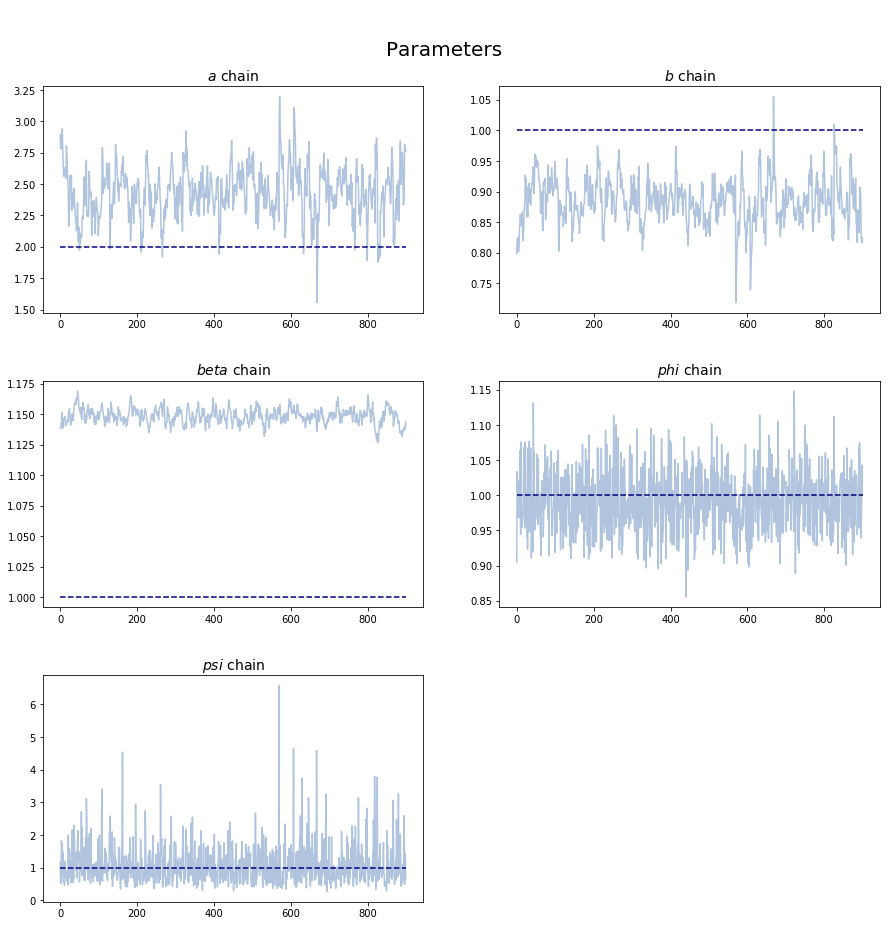

In [15]:
gibbs = GibbsSampler(df, iterations=1000, burn_in=100)
gibbs.fit()
gibbs.cut_the_burn()
gibbs.plot_the_chain(true_theta=theta)

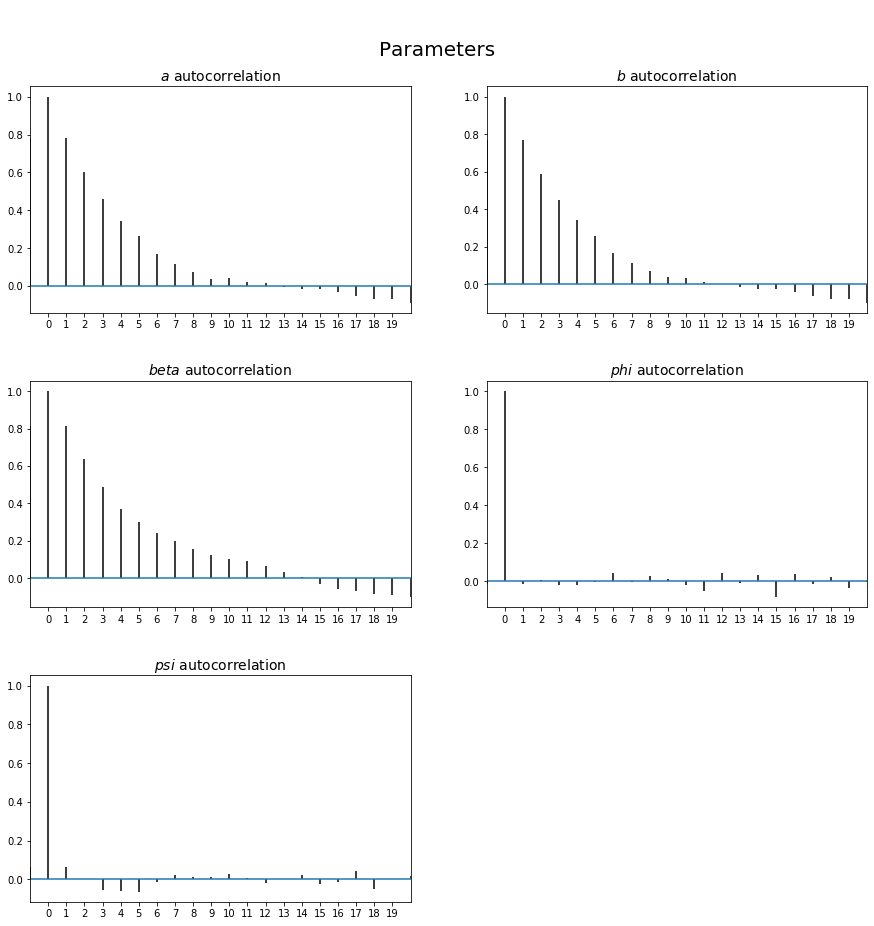

In [16]:
# autocorrelation
gibbs.plot_acf()
gibbs.thin_acf()

{'a': {'est_mean': 2.4337297445706736,
  'est_var': 0.039564689065632756,
  'confidence_interval': (2.043875767036526, 2.823583722104821)},
 'b': {'est_mean': 0.8843355327453306,
  'est_var': 0.001273567938685133,
  'confidence_interval': (0.814390134098849, 0.9542809313918122)},
 'beta': {'est_mean': 1.1483696235542924,
  'est_var': 3.720723088259061e-05,
  'confidence_interval': (1.1364142881233006, 1.1603249589852842)},
 'phi': {'est_mean': 0.9909164938117371,
  'est_var': 0.0018522554988781273,
  'shape': 532.1188190845551,
  'scale': 526.2943980046977,
  'confidence_interval': (0.9101183981079938, 1.0787784446833963)},
 'psi': {'est_mean': 1.0818125189530994,
  'est_var': 0.38231513636947057,
  'shape': 5.061135212372681,
  'scale': 4.393386913906021,
  'confidence_interval': (0.4253025678839462, 2.6502973826765315)}}

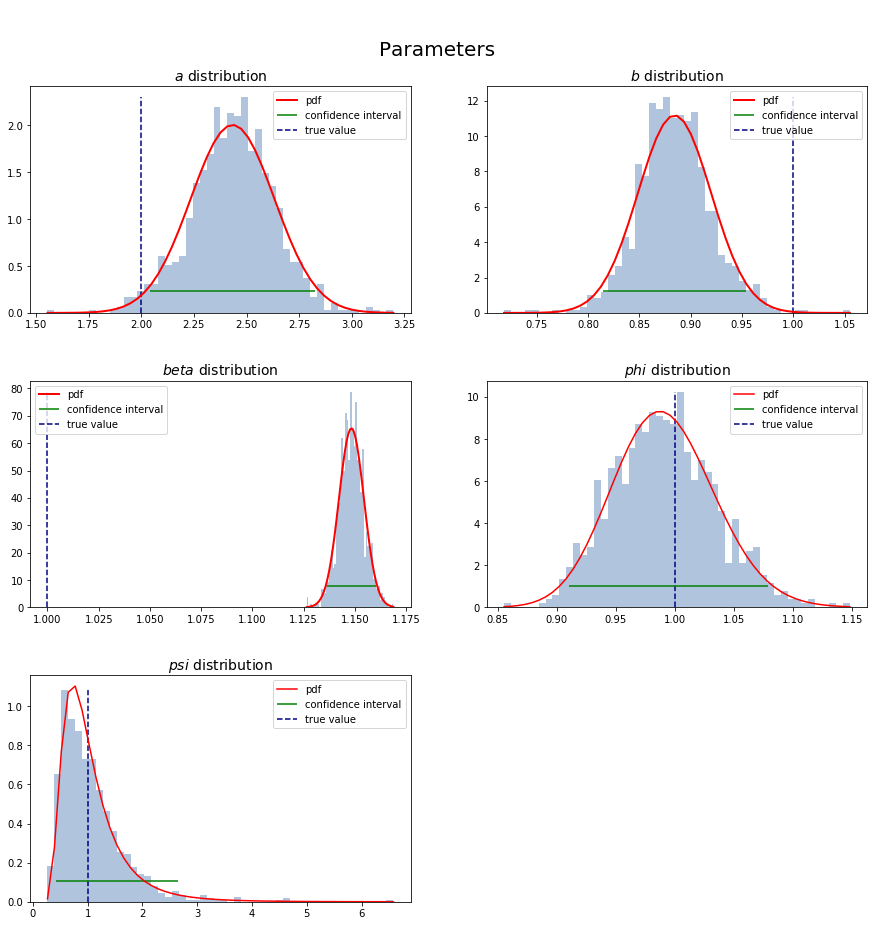

In [17]:
# posteriors
gibbs.dist_posterior_params()
gibbs.plot_posteriors(true_theta=theta)
gibbs.posteriors

# Radon Data
<a class="anchor" id="fourth"></a>

In [18]:
# radon data
srrs2 = pd.read_csv('http://www.stat.columbia.edu/~gelman/arm/examples/radon/srrs2.dat')
cty = pd.read_csv('http://www.stat.columbia.edu/~gelman/arm/examples/radon/cty.dat')
srrs2.columns = srrs2.columns.map(str.strip)

# Obtain the county-level predictor, uranium, by combining two variables.
srrs2['fips'] = 1000 * srrs2.stfips + srrs2.cntyfips
cty['fips'] = 1000 * cty.stfips + cty.ctfips

srrs2 = srrs2[srrs2.state=='MN']
cty = cty[cty.st=='MN']

# Use the merge method to combine home- and county-level information in a single DataFrame.
srrs2 = srrs2.merge(cty[['fips', 'Uppm']], on='fips')
srrs2 = srrs2.drop_duplicates(subset='idnum')

srrs2['county_name'] = srrs2.county.map(str.strip)
srrs2['uranium'] = np.log(srrs2.Uppm + 0.1)
srrs2['log_radon'] = np.log(srrs2.activity + 0.1).values
srrs2 = srrs2[['uranium', 'floor', 'log_radon', 'county_name']]
county_dictionary = {county:i for i, county in enumerate(srrs2.county_name.unique())}
county_dictionary = pd.DataFrame.from_dict(county_dictionary, orient='index')
county_dictionary = county_dictionary.reset_index().rename(columns={'index':'county_name', 0:'county'})
srrs2 = srrs2.merge(county_dictionary, how='left', on='county_name')
srrs2.rename(columns={'uranium': 'u',
                      'floor': 'x',
                      'log_radon': 'y',}, inplace=True)

In [19]:
print(srrs2.shape)
srrs2.head()

(919, 5)


,u,x,y,county_name,county
0,-0.507408,1,0.832909,AITKIN,0
1,-0.507408,0,0.832909,AITKIN,0
2,-0.507408,0,1.098612,AITKIN,0
3,-0.507408,0,0.095310,AITKIN,0
4,-0.637589,0,1.163151,ANOKA,1


## EM-Algorithm
<a class="anchor" id="fourth-first"></a>

In [20]:
em_test = Validation(srrs2)
em_test.run_em_validation()

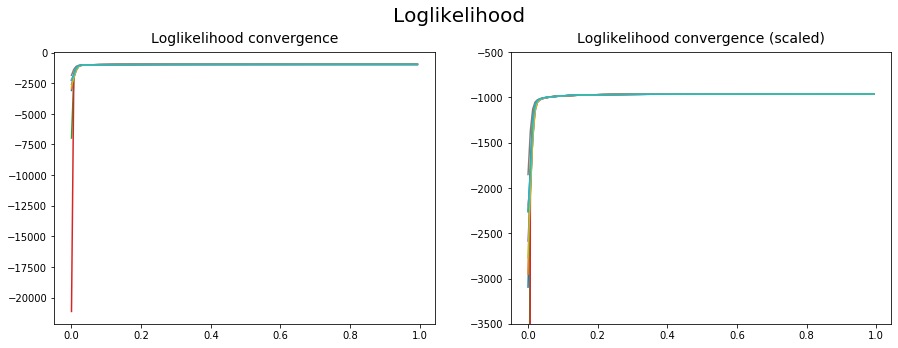

In [21]:
em_test.plot_likelihood(scale=(-3500, -500))

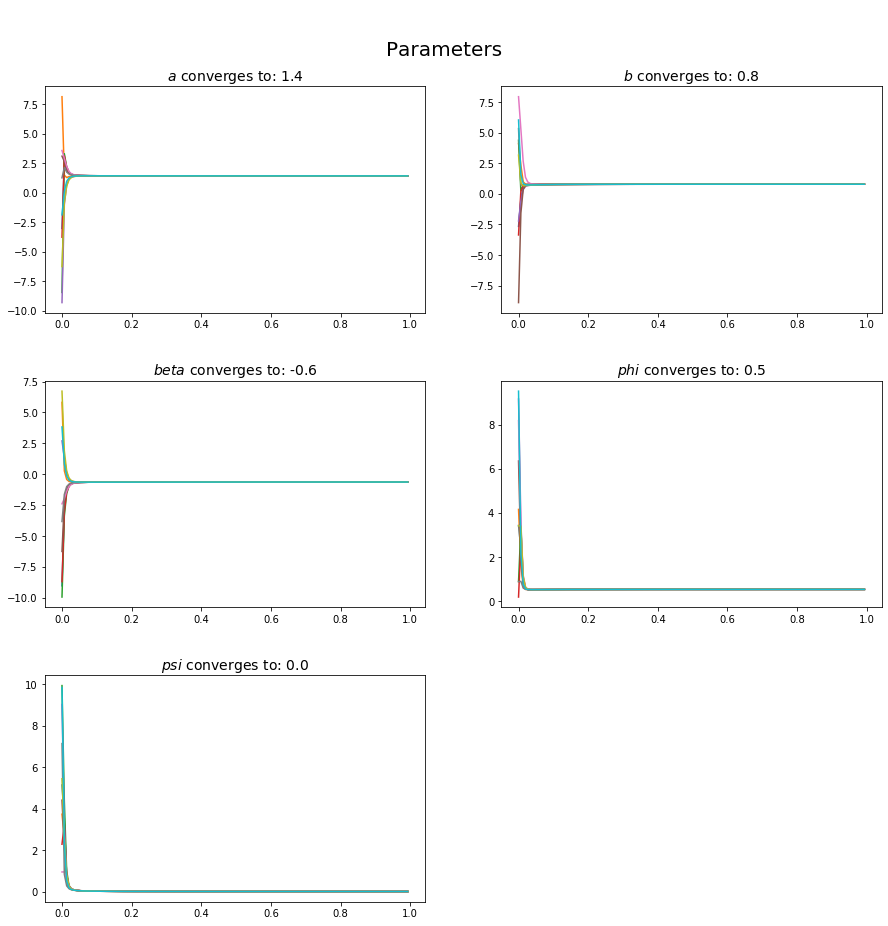

In [22]:
em_test.plot_theta()

## Gibbs Sampling
<a class="anchor" id="fourth-second"></a>
### External Implementation *pymc3* 
<a class="anchor" id="fourth-second-first"></a>

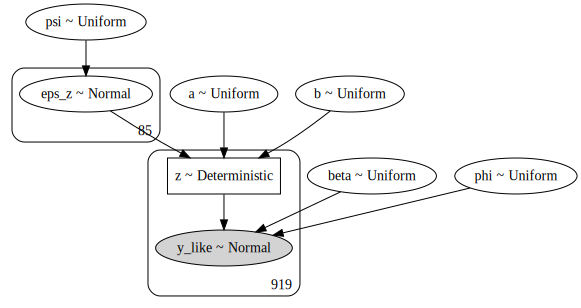

In [23]:
with Model() as hierarchical_intercept:

    psi = Uniform('psi', lower=0, upper=10)
    a = Uniform('a', lower=-10, upper=10)
    b = Uniform('b', lower=-10, upper=10)
    
    mu_z = a + b * srrs2['u']
    eps_z = Normal('eps_z', mu=0, sigma=psi, shape=len(srrs2.county.unique()))
    z = Deterministic('z', mu_z + eps_z[srrs2['county']])

    beta = Uniform('beta', lower=-10, upper=10)
    phi = Uniform('phi', lower=0, upper=10)
    
    y_hat = z + beta * srrs2['x']
    y_like = Normal('y_like', mu=y_hat, sigma=phi, observed=srrs2['y'])

model_to_graphviz(hierarchical_intercept)

In [24]:
with hierarchical_intercept:
    hierarchical_intercept_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, beta, eps_z, b, a, psi]
Sampling 4 chains, 0 divergences:  75%|███████▌  | 6000/8000 [00:31<00:10, 190.57draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [25]:
summary(hierarchical_intercept_trace, var_names=['a', 'b', 'psi', 'beta', 'phi'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.416,0.038,1.342,1.484,0.001,0.001,1048.0,1048.0,1027.0,1898.0,1.00
b,0.785,0.101,0.597,0.979,0.002,0.002,1956.0,1956.0,1958.0,2462.0,1.00
psi,0.153,0.047,0.048,0.224,0.004,0.003,121.0,121.0,120.0,99.0,1.02
beta,-0.640,0.064,-0.763,-0.519,0.001,0.001,2931.0,2931.0,2929.0,2222.0,1.00
phi,0.729,0.018,0.698,0.764,0.000,0.000,1578.0,1560.0,1598.0,1242.0,1.00



### Analytical Implementation
<a class="anchor" id="fourth-second-second"></a>

{'a': {'est_mean': 1.5112474940881542,
  'est_var': 4.930380657631324e-32,
  'confidence_interval': (1.5112474940881537, 1.5112474940881546)},
 'b': {'est_mean': 0.7876022413624734,
  'est_var': 4.930380657631324e-32,
  'confidence_interval': (0.7876022413624729, 0.7876022413624738)},
 'beta': {'est_mean': -0.7460483072687338,
  'est_var': 1.425945576029061e-05,
  'confidence_interval': (-0.7534494634019786, -0.7386471511354891)},
 'phi': {'est_mean': 0.5633581718122332,
  'est_var': 0.0006970248370199636,
  'shape': 457.324420151949,
  'scale': 257.07409109007943,
  'confidence_interval': (0.5139657242303488, 0.6174243181211324)},
 'psi': {'est_mean': 3.714333012193869e-33,
  'est_var': 3.3808808865993544e-67,
  'shape': 42.80673111009865,
  'scale': 1.5528412149415186e-31,
  'confidence_interval': (2.7459833974443342e-33, 5.016445349351368e-33)}}

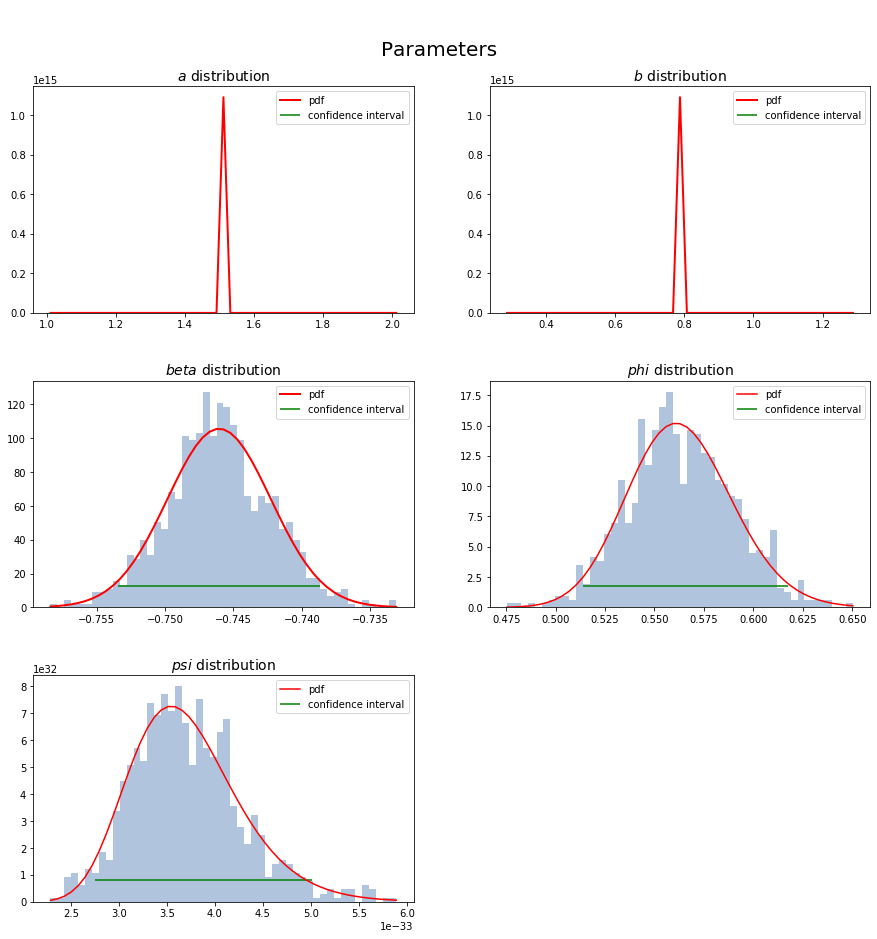

In [37]:
gibbs = GibbsSampler(srrs2, iterations=1000, burn_in=100)
gibbs.fit()
gibbs.cut_the_burn()
gibbs.thin_acf()
gibbs.dist_posterior_params()
gibbs.plot_posteriors()
gibbs.posteriors

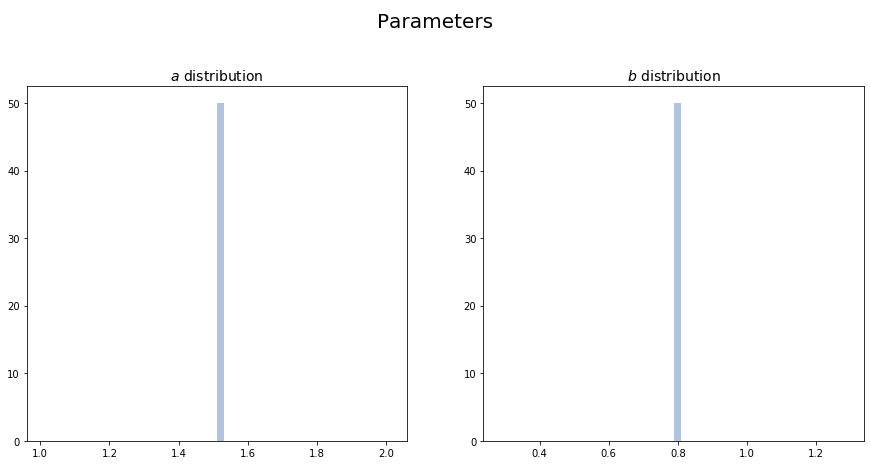

In [38]:
gibbs.plot_posteriors(parameters=['a', 'b'], plot_pdf=False)

# Robustness Checks and Experimentation
<a class="anchor" id="fifth"></a>
## Different Distributions for $x$ ($y$-covariate)
<a class="anchor" id="fifth-first"></a>
### Normal Distribution
<a class="anchor" id="fifth-first-first"></a>

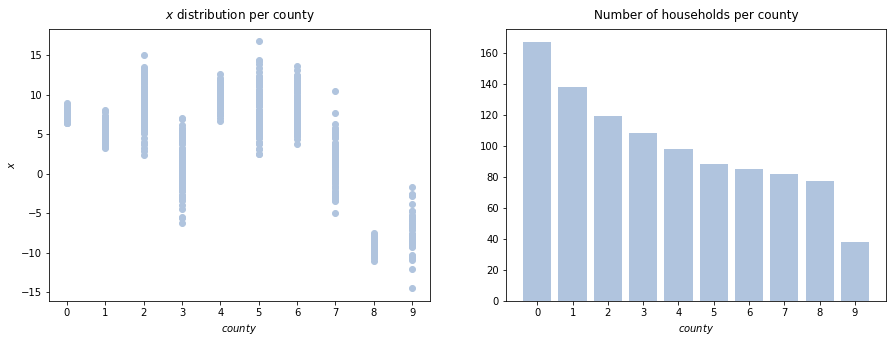

In [39]:
N = 1000
M = 10
theta = {'a':2, 'b':1, 'beta':1, 'psi':1, 'phi':0.1}

df_uz = generate_u_z(M, theta['a'], theta['b'], theta['psi'], u_distr='uniform', low=0, high=10)
num_households = generate_households_distribution(N, M, distr='gamma', shape=9, scale=1)
mean_param = np.random.uniform(-10, 10, M)
var_param = np.random.uniform(0, 5, M)
counties_params = list(zip(mean_param, var_param))
test = generate_x_y(df_uz, num_households, counties_params, theta['beta'], 
                    theta['phi'], x_distr='normal')

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
ax[0].scatter(test['county'], test['x'], color='lightsteelblue')
ax[0].set_title('$x$ distribution per county', pad=10)
ax[0].set_xticks(range(M))
ax[0].set_xlabel('$county$')
ax[0].set_ylabel('$x$')
ax[1].bar(x=range(M), height=num_households, color='lightsteelblue')
ax[1].set_title('Number of households per county', pad=10)
ax[1].set_xticks(range(M))
ax[1].set_xlabel('$county$');

In [40]:
run_ema(test)

{'a': 2.4688435570287495,
 'b': 0.8872585283879755,
 'beta': 1.0029828757358756,
 'phi': 0.09856474901363596,
 'psi': 0.776286783982638}

In [41]:
run_gibbs(test)

{'a': 2.4267037315023705,
 'b': 0.8946703202293751,
 'beta': 1.0029718718359037,
 'phi': 0.09829381445496109,
 'psi': 1.0701401856814776}

### Poisson Distribution
<a class="anchor" id="fifth-first-second"></a>

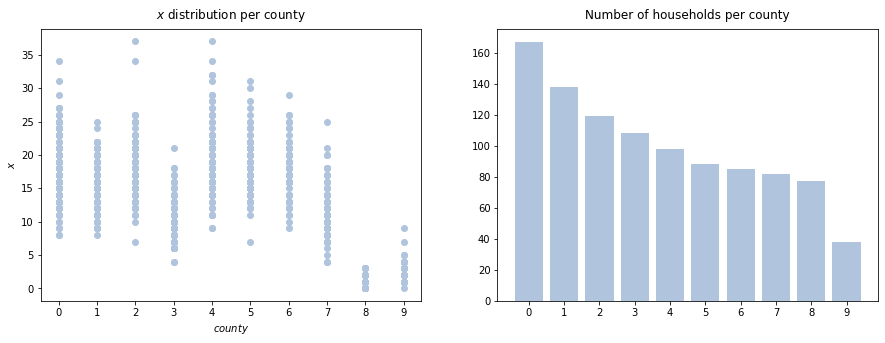

In [42]:
N = 1000
M = 10
theta = {'a':2, 'b':1, 'beta':1, 'psi':1, 'phi':0.1}

df_uz = generate_u_z(M, theta['a'], theta['b'], theta['psi'], u_distr='uniform', low=0, high=10)
num_households = generate_households_distribution(N, M, distr='gamma', shape=9, scale=1)
counties_params = np.random.uniform(0, 20, M)
test = generate_x_y(df_uz, num_households, counties_params, theta['beta'], theta['phi'], x_distr='poisson')

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
ax[0].scatter(test['county'], test['x'], color='lightsteelblue')
ax[0].set_title('$x$ distribution per county', pad=10)
ax[0].set_xticks(range(M))
ax[0].set_xlabel('$county$')
ax[0].set_ylabel('$x$')
ax[1].bar(x=range(M), height=num_households, color='lightsteelblue')
ax[1].set_title('Number of households per county', pad=10)
ax[1].set_xticks(range(M));

In [43]:
run_ema(test)

{'a': 2.4528583796392285,
 'b': 0.8871835378514732,
 'beta': 1.000817352476316,
 'phi': 0.10121033652836917,
 'psi': 0.7689399005525992}

In [44]:
run_gibbs(test)

{'a': 2.41276434839989,
 'b': 0.8944296798401968,
 'beta': 1.0007302137581844,
 'phi': 0.1009320526408034,
 'psi': 1.0600323213945457}

## Different Distributions for $u$ ($z$-covariate)
<a class="anchor" id="fifth-second"></a>
### Exponential Distribution
<a class="anchor" id="fifth-second-first"></a>

In [45]:
N = 1000
M = 10
theta = {'a':2, 'b':1, 'beta':1, 'psi':1, 'phi':0.1}

df_uz = generate_u_z(M, theta['a'], theta['b'], theta['psi'], u_distr='exponential', scale=.5)
num_households = generate_households_distribution(N, M, distr='gamma', shape=9, scale=1)
counties_params = np.random.uniform(0, 1, M)
test = generate_x_y(df_uz, num_households, counties_params, theta['beta'], theta['phi'], x_distr='binomial')

In [46]:
run_ema(test)

{'a': 2.4517241465867143,
 'b': 0.8872467033986385,
 'beta': 1.0008767960879033,
 'phi': 0.10121042346784936,
 'psi': 0.7688537704762759}

In [47]:
run_gibbs(test)

{'a': 2.412455151125557,
 'b': 0.894451461682075,
 'beta': 1.0007444130153635,
 'phi': 0.10093188567171255,
 'psi': 1.0600009093456053}

### Normal Distribution
<a class="anchor" id="fifth-second-second"></a>

In [48]:
N = 1000
M = 10
theta = {'a':2, 'b':1, 'beta':1, 'psi':1, 'phi':0.1}

df_uz = generate_u_z(M, theta['a'], theta['b'], theta['psi'], u_distr='normal', loc=0, scale=1)
num_households = generate_households_distribution(N, M, distr='gamma', shape=9, scale=1)
counties_params = np.random.uniform(0, 1, M)
test = generate_x_y(df_uz, num_households, counties_params, theta['beta'], theta['phi'], x_distr='binomial')

In [49]:
run_ema(test)

{'a': 2.457213445757349,
 'b': 0.8869410037694004,
 'beta': 1.0005891094049215,
 'phi': 0.10120989052476223,
 'psi': 0.7692703425214784}

In [50]:
run_gibbs(test)

{'a': 2.4122219070425834,
 'b': 0.8944678625734855,
 'beta': 1.0007551375694477,
 'phi': 0.10093188962569827,
 'psi': 1.0599776486112602}

## Correlation Level between $z$ and $x$
<a class="anchor" id="fifth-third"></a>
Here we check how algorithms estimate our parameters if we decrease "level of the correlation" between $x$ and $z$, i.e. we make distributions of $x$ between counties more similar to each other.

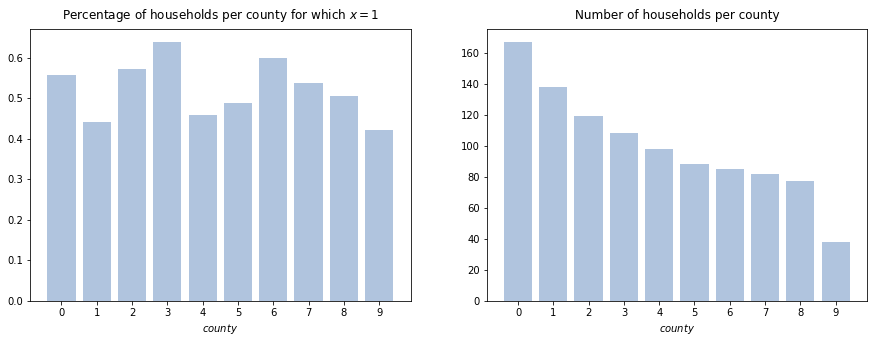

In [51]:
N = 1000
M = 10
theta = {'a':2, 'b':1, 'beta':1, 'psi':1, 'phi':0.1}

num_households = generate_households_distribution(N, M, distr='gamma', shape=9, scale=1)
counties_params = np.random.uniform(.5, .5, M)

df_uz = generate_u_z(M, theta['a'], theta['b'], theta['psi'], u_distr='uniform', low=0, high=10)
df = generate_x_y(df_uz, num_households, counties_params, theta['beta'], 
                  theta['phi'], x_distr='binomial')
test = df.copy()

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
ax[0].bar(range(M), df.groupby('county').sum().x / df.groupby('county').count().x, 
          color='lightsteelblue')
ax[0].set_title('Percentage of households per county for which $x=1$', pad=10)
ax[0].set_xticks(range(M))
ax[0].set_xlabel('$county$')
ax[1].bar(x=range(M), height=num_households, color='lightsteelblue')
ax[1].set_title('Number of households per county', pad=10)
ax[1].set_xticks(range(M))
ax[1].set_xlabel('$county$');

In [52]:
run_ema(test)

{'a': 2.4528321091852074,
 'b': 0.88718500084712,
 'beta': 1.0008187292802506,
 'phi': 0.10121031023915897,
 'psi': 0.7689378380451332}

In [53]:
run_gibbs(test)

{'a': 2.4118301174680283,
 'b': 0.8944953530338876,
 'beta': 1.0007731778106974,
 'phi': 0.10093214878190682,
 'psi': 1.0599394203965784}

## Number of Households per County
<a class="anchor" id="fifth-fourth"></a>
Here we evaluate performance of the algorithms with a skewed distribution of houses per county.

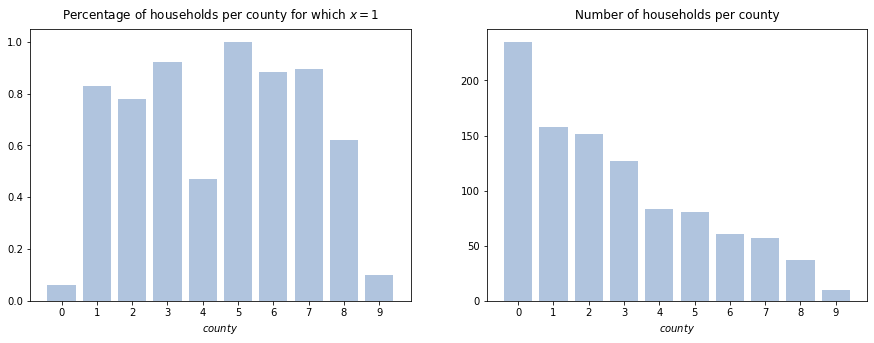

In [8]:
N = 1000
M = 10
theta = {'a':2, 'b':1, 'beta':1, 'psi':1, 'phi':0.1}

num_households = generate_households_distribution(N, M, distr='gamma', scale=0.005, shape=1.5)
counties_params = np.random.uniform(0, 1, M)

df_uz = generate_u_z(M, theta['a'], theta['b'], theta['psi'], u_distr='uniform', low=0, high=10)
df = generate_x_y(df_uz, num_households, counties_params, theta['beta'], theta['phi'], x_distr='binomial')
test = df.copy()

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
ax[0].bar(range(M), df.groupby('county').sum().x / df.groupby('county').count().x, color='lightsteelblue')
ax[0].set_title('Percentage of households per county for which $x=1$', pad=10)
ax[0].set_xticks(range(M))
ax[0].set_xlabel('$county$')
ax[1].bar(x=range(M), height=num_households, color='lightsteelblue')
ax[1].set_title('Number of households per county', pad=10)
ax[1].set_xticks(range(M))
ax[1].set_xlabel('$county$');

In [12]:
run_ema(test)

{'a': 2.4495915691025076,
 'b': 0.8973513337489001,
 'beta': 0.9716638539647915,
 'phi': 0.09930617947107848,
 'psi': 0.7689189362882309}

In [13]:
run_gibbs(test)

{'a': 2.4078848157093713,
 'b': 0.9046835380325334,
 'beta': 0.9716804774025453,
 'phi': 0.09903625853692934,
 'psi': 1.0586903523341349}

## Number of Counties
<a class="anchor" id="fifth-fifth"></a>
Here we test whether higher number of counties with the same number of data influences performance of the algorithms.

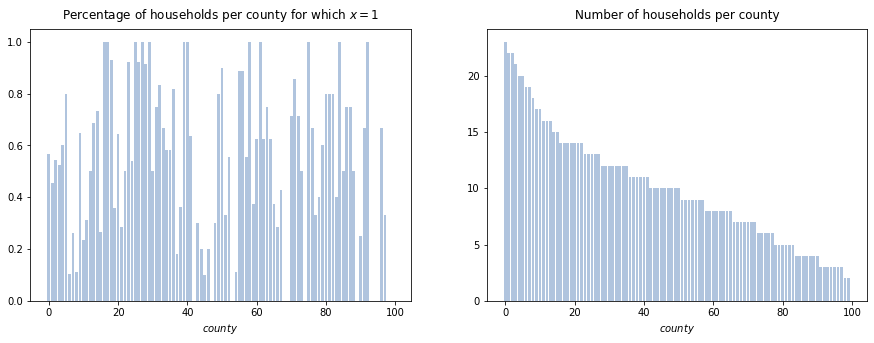

In [57]:
N = 1000
M = 100
theta = {'a':2, 'b':1, 'beta':1, 'psi':1, 'phi':0.1}

num_households = generate_households_distribution(N, M, distr='gamma', shape=9, scale=1)
counties_params = np.random.uniform(0, 1, M)

df_uz = generate_u_z(M, theta['a'], theta['b'], theta['psi'], u_distr='uniform', low=0, high=10)
df = generate_x_y(df_uz, num_households, counties_params, theta['beta'], theta['phi'], x_distr='binomial')
test = df.copy()

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
ax[0].bar(range(M), df.groupby('county').sum().x / df.groupby('county').count().x, color='lightsteelblue')
ax[0].set_title('Percentage of households per county for which $x=1$', pad=10)
ax[0].set_xlabel('$county$')
ax[1].bar(x=range(M), height=num_households, color='lightsteelblue')
ax[1].set_title('Number of households per county', pad=10)
ax[1].set_xlabel('$county$');

In [58]:
run_ema(test)

{'a': 2.454971834144435,
 'b': 0.8870658393478081,
 'beta': 1.0007065892125406,
 'phi': 0.10121010691765006,
 'psi': 0.7691002280920172}

In [59]:
run_gibbs(test)

{'a': 2.4370722240575473,
 'b': 0.8899556282036599,
 'beta': 1.0007557803457672,
 'phi': 0.10069555609074915,
 'psi': 1.0922656708672374}